In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
from local_models.plotting_utils import mayavi_plt_pts
from local_models.tf_quadric_models import *
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import csv
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import pandas as pd
import itertools
import collections

from local_models.quadric_models import *
from local_models.plotting_utils import *
import joblib


#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
FRESH=True

In [3]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
example_data = np.loadtxt("/home/brown/disk2/shapenet/train_data/02691156/000176.pts")

In [6]:
example_labels = np.loadtxt("/home/brown/disk2/shapenet/train_label/02691156/000176.seg")

In [7]:
example_data.shape, example_labels.shape

((2552, 3), (2552,))

In [8]:
np.std(example_data,axis=0)

array([0.15554406, 0.03679307, 0.11109593])

In [9]:
#scale the data.... having underflow errors
example_data = example_data*1/np.min(np.std(example_data, axis=0))

In [10]:
np.std(example_data,axis=0)

array([4.22753651, 1.        , 3.01947946])

In [11]:
def grid_param_iterator(param_grid):
    return map(dict, itertools.product(*itertools.starmap(itertools.product, zip(map(
            lambda x: (x,), param_grid.keys()), param_grid.values()))))

In [66]:
kernel_param_grid = collections.OrderedDict((
    ("bandwidth", ["knn"]),
    ("k", [15])))#,50,100])))
feature_weight_param_grid = collections.OrderedDict((
    ("alpha", [1.]),
    ("beta", [0.]),
    ("gamma", [0.]),
    ("eta", [0.]),
    ("zeta", [0.])))
#meanshift_param_grid = collections.OrderedDict((("bandwidth", [1,2,5,10,20]),))
meanshift_param_grid = collections.OrderedDict((("bandwidth", [1.5,1.75,2.25,2.5,2.75,3.]),))
#meanshift_param_grid = collections.OrderedDict((("bandwidth", sorted([1,2,5,10,20] + [1.5,1.75,2.25,2.5,2.75,3.])),))

In [67]:
list(grid_param_iterator(kernel_param_grid))

[{'bandwidth': 'knn', 'k': 15}]

In [68]:
KERNEL=local_models.local_models.TriCubeKernel

project_dir = "../data/shapenet_gridsearch"
os.makedirs(project_dir, exist_ok=1)

In [69]:
def local_odq_shift_parallel(unfitted_quadric_models, fit_data, predict_data, 
    iterations=100, kernel=None, batch_size=100, n_jobs=32, previous_beta0=False, model_updater=None, return_params=False):
    
    base_batch = np.array([0,batch_size])
    n_batches = predict_data.shape[0]/batch_size

    slicers = [slice(*(base_batch + batch_size*n)) for n in range(int(np.ceil(n_batches)))]

    iterated_predictionses = joblib.Parallel(n_jobs=n_jobs, verbose=100)(joblib.delayed(local_odq_shift_unfitted)(
                unfitted_quadric_models,
                fit_data,
                predict_data[slicer],
                iterations=iterations,
                kernel=kernel,
                previous_beta0=previous_beta0,
                model_updater=model_updater,
                return_params=return_params,
                identifier=slicer
            )
            for slicer in slicers
        )
    logger.info("finished")
    return iterated_predictionses

In [70]:
def mean_shift_unfitted(unfitted_mean_models, fit_data, predict_data, iterations=100, kernel=None):
    mean_models = unfitted_mean_models.fit(fit_data)
    for shift in local_models.algorithms.mean_shift(
        mean_models, predict_data, iterations=iterations, kernel=kernel): pass
    return shift

def mean_shift_parallel(unfitted_mean_models, fit_data, predict_data, iterations=100, kernel=None, batch_size=None, n_jobs=8):
    
    if batch_size is None:
        batch_size = int(np.ceil(predict_data.shape[0]/n_jobs))
        
    base_batch = np.array([0,batch_size])
    n_batches = int(np.ceil(predict_data.shape[0]/batch_size))

    slicers = [slice(*(base_batch + batch_size*n)) for n in range(n_batches)]

    iterated_predictionses = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(mean_shift_unfitted)(
                unfitted_mean_models,
                fit_data,
                predict_data[slicer],
                iterations=iterations,
                kernel=kernel
            )
            for slicer in slicers
        )

    return iterated_predictionses

In [196]:
TRIU_INDICES4 = np.triu_indices(4)
def regularize_param_vectors(X,P):
    #alpha, beta, gamma, eta and zeta are the relative weights of: 
    #alpha :: curvature, 
    #beta  :: offset of parabola vertex from point
    #gamma :: some combo of total offset and intercept
    #eta   :: direction of parabola
    #zeta  :: original points
    rearranged = np.zeros((P.shape[0], 4, 4))
    rearranged[:,TRIU_INDICES4[0], TRIU_INDICES4[1]] = P
    rearranged[:,TRIU_INDICES4[1], TRIU_INDICES4[0]] = P
    Ls, Us, ULs, URs, BRs = map(np.empty, ((P.shape[0],3), (P.shape[0],3,3), (P.shape[0],3), (P.shape[0],1,3), (P.shape[0],1,1)))
    for i, Q in enumerate(rearranged):
        x = X[i:i+1]
        Q_s = Q[:-1,:-1]
        L, U = np.linalg.eigh(Q_s)
        
        #easy indexing is row-wise, so we transpose U for now
        U = U.T
        
        absL_sorter = np.argsort(np.abs(L), axis=-1)
        L = L[absL_sorter]
        U = U[absL_sorter]
        
        non0L_sorter = np.argsort(L[1:], axis=-1)
        L[1:] = L[1:][non0L_sorter]
        U[1:] = U[1:][non0L_sorter]
        
        #untranspose U from before
        U = U.T
        
        #there is a zero eig.... find it
        
        UTQs = U.T@Q_s
        UL = L
        UR = x@UTQs.T + Q[-1:,:-1]@U
        BR = np.einsum('kj,kj->k', x@Q_s, x).reshape(-1,1) + 2*x@Q[-1:,:-1].T + Q[-1,-1]
        
        
        Ls[i], Us[i], ULs[i], URs[i], BRs[i] = L, U, UL, UR, BR

    #return ULs, Us, URs, BRs

    return Us, ULs, URs, BRs
    
def featurify_param_vectors(X,P,alpha=1.,beta=1.,gamma=1.,eta=1.,zeta=1.):
    Us,ULs,URs,BRs = regularize_param_vectors(X,P)
    
    curv = ULs[:,1:]
    pos = URs[:,0,1:]/ULs[:,1:]
    offset = BRs[:,0] - np.sum(pos**2, axis=-1, keepdims=True)
    norm = Us[:,:,0]/np.sign(URs[:,0,0]).reshape(-1,1)
    pt = X
    print(curv.shape, pos.shape, offset.shape, norm.shape, pt.shape)
    
    features = np.concatenate((alpha*curv, beta*pos, gamma*offset, eta*norm, zeta*pt), axis=1)
    return features/np.sum([alpha,beta,gamma,eta,zeta])
    

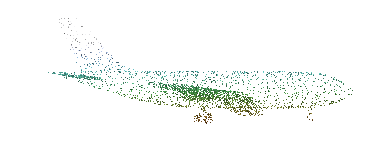

In [72]:
mayavi_plt_pts(example_data)

In [73]:
with fuckit("nothing to del"):
    TFQuadricSesh.close()
with fuckit("nothing to del"):
    del TFQuadricSesh 
with fuckit("nothing to del"):
    del TFQuadricGraph 
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricSesh
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricGraph

nothing to del
nothing to del
nothing to del
nothing to del
nothing to del


In [74]:
parabolic_model = TFParabolic(n_epochs=20000, log_epochs=0.01, weighted=True)

building!
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(3, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_2:0", shape=(3, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_2:0", shape=(?, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_4:0", shape=(?, 1), dtype=complex128)
args0 Tensor("quadric_regression/quadric_projection/cond/strided_slice_2:0", shape=(?, 1), dtype=complex128)
(?, 1)
args1 Tensor("quadric_regression/quadric_projection/cond/strided_slice_3:0", shape=(?, 1), dtype=complex128)
(?, 1)
args2 Tensor("quad

special_pts Tensor("quadric_regression/quadric_projection/cond_1/Merge:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/GatherV2_1:0", shape=(3,), dtype=float64)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/concat_3:0", shape=(3,), dtype=float64)
(4, 4)


In [75]:
local_quadrics = local_models.local_models.LocalModels(parabolic_model)

In [76]:
local_quadrics.fit(example_data)

In [77]:
class BaseBandwidthGaussianKernel(local_models.local_models.GaussianKernel):
    #this is strictly for grid search over bandwidth *multipliers*
    def __init__(self, bandwidth=None, base_bandwidth=1.):
        super().__init__(bandwidth=bandwidth*base_bandwidth)
        

In [78]:
def unique(arr_of_arr):
    sorted_arr_of_arr = []
    for arr in arr_of_arr:
        sorted_arr_of_arr.append(np.sort(arr))
    unique_arr_of_arr = []
    for arr in sorted_arr_of_arr:
        isunique = True
        for uarr in unique_arr_of_arr:
            if len(uarr) != len(arr): continue
            same = True
            for i in range(len(arr)):
                if arr[i] != uarr[i]: 
                    same = False
                    break
            if same:
                isunique = False
                break
        if isunique:
            unique_arr_of_arr.append(arr)
    return unique_arr_of_arr

In [79]:
def plot(pts, cluster_arr, plt_file):
    mayavi.mlab.options.offscreen = True
    figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
    focus = np.average(pts, axis=0)
    dist = np.std(pts, axis=0)

    nodes = mayavi.mlab.points3d(pts[:,0], pts[:,1], pts[:,2],
                                 scale_mode='scalar', scale_factor=1,
                                 colormap='gist_rainbow', figure=figure, vmin=0, vmax=int(np.max(cluster_arr))+1)
    nodes.glyph.scale_mode = 'scale_by_vector'
    #sizes
    nodes.mlab_source.dataset.point_data.vectors = np.ones((pts.shape[0],3))*(np.average(dist)/20)
    #colors
    nodes.mlab_source.dataset.point_data.scalars = cluster_arr  
    normalize_view(figure, focus, dist, azimuth=45, elevation=-65, roll=15)
    mayavi.mlab.savefig(plt_file, figure=figure, magnification=2)
    mayavi.mlab.clf(figure)
    mayavi.mlab.close(figure)

In [80]:
def seg2pdist(seg):
    labels, counts = np.unique(seg, return_counts=True, axis=0)
    return labels, counts/seg.shape[0]

def H(pdist):
    # entropy
    return -np.sum(pdist*np.log2(pdist))
    
def I(seg1, seg2):
    seg12 = np.stack((seg1,seg2), axis=-1)
    labels, pdist12 = seg2pdist(seg12)
    _, marginal1_i, marginal1_ii = np.unique(
        labels[:,0], return_index=True, return_inverse=True)
    _, marginal2_i, marginal2_ii = np.unique(
        labels[:,1], return_index=True, return_inverse=True)
        
    marginal1 = np.zeros(marginal1_i.shape)
    for i,j in enumerate(marginal1_ii):
        marginal1[j] += pdist12[i]
    marginal1 = marginal1/np.sum(marginal1)
    
    marginal2 = np.zeros(marginal2_i.shape)
    for i,j in enumerate(marginal2_ii):
        marginal2[j] += pdist12[i]
    marginal2 = marginal2/np.sum(marginal2)
    
    return np.sum(pdist12*np.log2(pdist12/(marginal1[marginal1_ii]*marginal2[marginal2_ii])))

def VOI(seg1, seg2):
    _, pdist1 = seg2pdist(seg1)
    _, pdist2 = seg2pdist(seg2)
    H1, H2, I12 = H(pdist1), H(pdist2), I(seg1, seg2)
    return H1 + H2 - 2*I12

In [88]:
for feature_weight_param_kwargs in itertools.islice(
    grid_param_iterator(feature_weight_param_grid),0,None):
    print(feature_weight_param_kwargs)

{'alpha': 1.0, 'eta': 0.0, 'beta': 0.0, 'gamma': 0.0, 'zeta': 0.0}


In [ ]:
first_level_timelog = local_models.loggin.TimeLogger(
    logger=logger, how_often=1, total = np.prod(list(map(len, kernel_param_grid.values()))), 
    tag="shapenet_gridsearch_quadric_kernel_params")
second_level_timelog = local_models.loggin.TimeLogger(
    logger=logger, how_often=1, 
    total = np.prod(list(map(len, feature_weight_param_grid.values())))-1,
    tag="shapenet_gridsearch_feature_param_grid")
    
voi_csv = os.path.join(project_dir, "voi_csv")
make_voi_csv=False
if not os.path.exists(voi_csv):
    make_voi_csv=True

for kernel_param_kwargs in grid_param_iterator(kernel_param_grid):
    with first_level_timelog:
        kernel_param_dir = os.path.join(project_dir, str(tuple(sorted(kernel_param_kwargs.items()))))
        os.makedirs(kernel_param_dir, exist_ok=1)
        quadric_params_file = os.path.join(kernel_param_dir, "quadric_params")
        kernel = KERNEL(**kernel_param_kwargs)
        try:
            quadric_params = np.loadtxt(quadric_params_file)
        except OSError:
            with joblib.parallel_backend("loky", n_jobs=8):
                quadric_params = local_quadrics.transform(example_data, k=kernel.k, kernel=kernel, weighted=True,
                    parallel=True)
            np.savetxt(quadric_params_file, quadric_params)

        for feature_weight_param_kwargs in itertools.islice(
            grid_param_iterator(feature_weight_param_grid),0,None):
            with second_level_timelog:
                features_dir = os.path.join(kernel_param_dir, 
                    "features_{}".format(str(tuple(sorted(feature_weight_param_kwargs.items())))))
                os.makedirs(features_dir, exist_ok=1)
                features_file = os.path.join(features_dir, "features")

                try:
                    features = np.loadtxt(features_file)
                except OSError:
                    features = featurify_param_vectors(example_data, quadric_params, **feature_weight_param_kwargs)
                    np.savetxt(features_file, features)

                for meanshift_param_kwargs in grid_param_iterator(meanshift_param_grid):
                    shift_file = os.path.join(features_dir, 
                        "ms_{}".format(str(tuple(sorted(meanshift_param_kwargs.items())))))
                    try:
                        cluster_arr = np.loadtxt(shift_file)
                    except OSError:
                        mean_model = local_models.local_models.TLS_models.Mean()
                        mean_models = local_models.local_models.LocalModels(mean_model)
                        #mean_models.fit(features)
                        bt = sklearn.neighbors.BallTree(features)
                        average_nn_dist = np.mean(bt.query(features, k=2, return_distance=True)[0][:,1])
                        ms_kernel = functools.partial(
                            BaseBandwidthGaussianKernel, base_bandwidth=average_nn_dist)(
                                **meanshift_param_kwargs)
                        print(features.shape)
                        #shifter = local_models.algorithms.mean_shift(mean_models, features, iterations=200, kernel=ms_kernel)
                        #for shift in shifter: pass
                        #print(shift.shape)
                        shift = mean_shift_parallel(
                            mean_models, features, features, iterations=200, kernel=ms_kernel, n_jobs=16)
                        shift = np.concatenate(shift, axis=0)

                        shift_tree = sklearn.neighbors.BallTree(shift)
                        clusters = shift_tree.query_radius(shift, r=average_nn_dist/10)
                        print(clusters)

                        cluster_map = collections.defaultdict(list)
                        for j, cluster in enumerate(unique(clusters)):
                            for i in cluster:
                                cluster_map[i].append(j)
                        cluster_arr = np.array([cluster_map[i][0] for i in sorted(cluster_map)])
                        print(np.unique(cluster_arr).shape)
                        np.savetxt(shift_file, cluster_arr,fmt="%u")

                    plt_file = shift_file + ".png"
                    if not os.path.exists(plt_file):
                        pts = example_data
                        joblib.Parallel(n_jobs=2)(joblib.delayed(plot)(
                            pts,
                            cluster_arr,
                            plt_file) for i in range(1))
                        
                    voi_file = shift_file + "cluster_voi_gt.png"
                    if not os.path.exists(voi_file):
                        random_label_dist = [
                            VOI(example_labels, 
                                np.random.choice(np.unique(cluster_arr), 
                                                 example_labels.shape)) for i in range(100)]
                        v = VOI(cluster_arr, example_labels)
                        m,s = np.mean(random_label_dist), np.std(random_label_dist)
                        z = (m-v)/s

                        plt.hist(random_label_dist)
                        plt.axvline(v, c='r')
                        plt.title("m={}; s={}; z={}".format(m,s,z))
                        plt.savefig(voi_file)
                        plt.clf()
                        with open(voi_csv, "a") as f:
                            writer = csv.writer(f, delimiter=',')
                            d1 = list(zip(*tuple(sorted(kernel_param_kwargs.items()))))[1]
                            d2 = list(zip(*tuple(sorted(feature_weight_param_kwargs.items()))))[1]
                            d3 = list(zip(*tuple(sorted(meanshift_param_kwargs.items()))))[1]
                            d4 = [v,m,s,z]
                            data = sum(map(list, [d1,d2,d3,d4]), [])
                            writer.writerow(data)

(2552, 2562)


In [ ]:
list(zip(*tuple(sorted(kernel_param_kwargs.items()))))[1]

In [ ]:
np.random.choice(np.unique(cluster_arr), example_labels.shape)

In [ ]:
random_label_dist = [
    VOI(example_labels, np.random.choice(np.unique(cluster_arr), example_labels.shape)) for i in range(10000)]

In [ ]:
VOI(cluster_arr, example_labels)

In [ ]:
kernel_param_grid, feature_weight_param_grid, meanshift_param_grid

In [ ]:
kernel_param_kwargs, feature_weight_param_kwargs, meanshift_param_kwargs

In [ ]:
kernel_param_kwargs = {"bandwidth":"knn", "k":10}
feature_weight_param_kwargs = {
    "alpha":0.,
    "beta":1.,
    "eta":1.,
    "gamma":0.,
    "zeta":2.
}
meanshift_param_kwargs = {"bandwidth": 1.75}

In [ ]:
kernel_param_dir = os.path.join(project_dir, str(tuple(sorted(kernel_param_kwargs.items()))))
features_dir = os.path.join(kernel_param_dir, 
    "features_{}".format(str(tuple(sorted(feature_weight_param_kwargs.items())))))
shift_file = os.path.join(features_dir, 
    "ms_{}".format(str(tuple(sorted(meanshift_param_kwargs.items())))))
cluster_arr = np.loadtxt(shift_file)

In [ ]:
np.unique(cluster_arr, return_counts=True)

In [ ]:
random_label_dist = [
    VOI(example_labels, 
        np.random.choice(np.unique(cluster_arr), 
                         example_labels.shape)) for i in range(10000)]
v = VOI(cluster_arr, example_labels)
m,s = np.mean(random_label_dist), np.std(random_label_dist)
z = (m-v)/s

plt.hist(random_label_dist)
plt.axvline(v, c='r')

In [ ]:
H(seg2pdist(cluster_arr)[1])

In [ ]:
H(seg2pdist(example_labels)[1])

In [ ]:
cluster_arr

In [ ]:
I(cluster_arr, example_labels)

In [ ]:
VOI(cluster_arr, example_labels)

In [ ]:
I(example_labels, cluster_arr)

In [ ]:
joblib.Parallel(n_jobs=2)(joblib.delayed(plot)(
    example_data, example_labels, os.path.join(project_dir, "ground_truth_labels.png")) for i in range(1))

In [ ]:
os.path.join(project_dir, "ground_truth_labels.png")

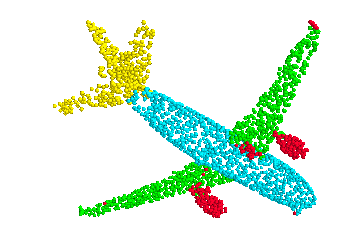

In [135]:
imshow(os.path.join(project_dir, "ground_truth_labels.png"))

In [92]:
h1 = map(lambda x: "kern_" + x, list(zip(*tuple(sorted(kernel_param_kwargs.items()))))[0])
h2 = map(lambda x: "feat_" + x, list(zip(*tuple(sorted(feature_weight_param_kwargs.items()))))[0])
h3 = map(lambda x: "ms_" + x, list(zip(*tuple(sorted(meanshift_param_kwargs.items()))))[0])
h4 = ["voi","m_voi","s_voi","z_voi"]
header = sum(map(list, [h1,h2,h3,h4]), [])

In [93]:
vois = pd.read_csv(voi_csv, delimiter=",", header=None, names=header)

In [94]:
vois

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
0,knn,10,0.0,0.0,0.0,0.0,2.0,1.50,5.062128,8.547773,0.017594,198.110334
1,knn,10,0.0,0.0,0.0,0.0,2.0,1.75,4.711245,8.375426,0.014114,259.605242
2,knn,10,0.0,0.0,0.0,0.0,2.0,2.25,4.055953,7.869261,0.013455,283.417904
3,knn,10,0.0,0.0,0.0,0.0,2.0,2.50,3.792948,7.632582,0.010782,356.113545
4,knn,10,0.0,0.0,0.0,0.0,2.0,2.75,3.736992,7.955202,0.014028,300.704254
5,knn,10,0.0,0.0,0.0,0.0,2.0,3.00,3.357127,6.384572,0.007169,422.283871
6,knn,10,0.0,0.0,1.0,0.0,0.0,1.50,8.204829,9.157924,0.022671,42.039832
7,knn,10,0.0,0.0,1.0,0.0,0.0,1.75,7.711248,8.761177,0.019547,53.712419
8,knn,10,0.0,0.0,1.0,0.0,0.0,2.25,7.131877,8.138468,0.014657,68.674812
9,knn,10,0.0,0.0,1.0,0.0,0.0,2.50,6.862939,7.851785,0.014202,69.626298


In [95]:
vois[(vois["kern_k"] == 15) & (vois["feat_alpha"] == 1)]

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
206,knn,15,1.0,0.0,0.0,0.0,2.0,1.50,4.334932,7.736565,0.010580,321.504972
207,knn,15,1.0,0.0,0.0,0.0,2.0,1.75,3.932850,7.738415,0.010818,351.774074
208,knn,15,1.0,0.0,0.0,0.0,2.0,2.25,3.418368,7.155335,0.009713,384.726027
209,knn,15,1.0,0.0,0.0,0.0,2.0,2.50,3.182939,6.324308,0.006500,483.268809
210,knn,15,1.0,0.0,0.0,0.0,2.0,2.75,2.933190,5.625089,0.005847,460.397331
211,knn,15,1.0,0.0,0.0,0.0,2.0,3.00,2.774617,5.407597,0.004132,637.288843
212,knn,15,1.0,0.0,1.0,0.0,0.0,1.50,4.861787,5.520544,0.004976,132.378516
213,knn,15,1.0,0.0,1.0,0.0,0.0,1.75,4.752874,5.284844,0.004250,125.164877
214,knn,15,1.0,0.0,1.0,0.0,0.0,2.25,4.194169,4.640627,0.003098,144.092015
215,knn,15,1.0,0.0,1.0,0.0,0.0,2.50,3.930382,4.420087,0.003364,145.582983


In [31]:
np.argmin(vois["voi"]/vois["m_voi"])

197

In [32]:
vois.iloc[np.argmin(vois["voi"])]

kern_bandwidth           knn
kern_k                    10
feat_alpha                 0
feat_beta                  0
feat_eta                   5
feat_gamma                 0
feat_zeta                  2
ms_bandwidth               3
voi                  1.39846
m_voi                2.84267
s_voi             0.00123002
z_voi                1174.14
Name: 41, dtype: object

In [33]:
def folder_formatter(row):
    f1 = str((("bandwidth", row["kern_bandwidth"]), ("k", row["kern_k"])))
    f2 = "features_" + str(tuple(map(lambda n: (n, row["feat_" + n]), ["alpha","beta","eta","gamma","zeta"])))
    f3 = "ms_" + str((("bandwidth", row["ms_bandwidth"]),))
    return os.path.join(project_dir, f1, f2, f3)

In [34]:
foo = np.loadtxt(folder_formatter(vois.iloc[np.argmax(vois["z_voi"])]))
folder_formatter(vois.iloc[np.argmax(vois["z_voi"])])

"../data/shapenet_gridsearch/(('bandwidth', 'knn'), ('k', 15))/features_(('alpha', 0.0), ('beta', 0.0), ('eta', 5.0), ('gamma', 0.0), ('zeta', 2.0))/ms_(('bandwidth', 2.75),)"

(array([2078.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         474.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

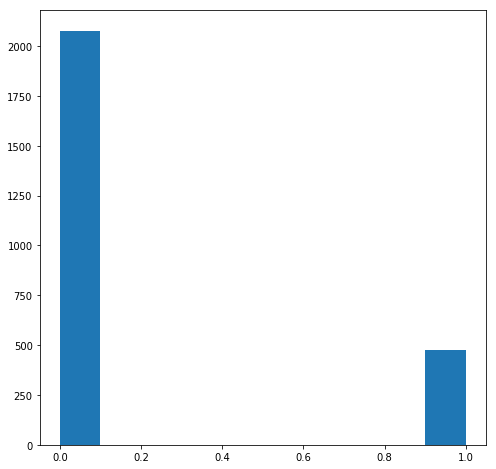

In [35]:
plt.hist(foo)

In [36]:
vois.iloc[np.argmax(vois["z_voi"])]

kern_bandwidth           knn
kern_k                    15
feat_alpha                 0
feat_beta                  0
feat_eta                   5
feat_gamma                 0
feat_zeta                  2
ms_bandwidth            2.75
voi                  1.46776
m_voi                2.84313
s_voi             0.00109246
z_voi                1258.97
Name: 129, dtype: object

In [37]:
vois.iloc[np.argmin(vois["voi"]/vois["m_voi"])]

kern_bandwidth           knn
kern_k                    15
feat_alpha                 0
feat_beta                  1
feat_eta                   1
feat_gamma                 0
feat_zeta                  2
ms_bandwidth             1.5
voi                  1.92212
m_voi                7.01772
s_voi             0.00866334
z_voi                 588.18
Name: 197, dtype: object

In [38]:
lock = ["kern_k","feat_beta","feat_eta","feat_gamma","feat_zeta","ms_bandwidth"]
vois[
    np.logical_not(np.any(vois[lock] -
    vois.iloc[np.argmin(vois["voi"])][lock], axis=1))]

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
41,knn,10,0.0,0.0,5.0,0.0,2.0,3.0,1.398455,2.842666,0.00123,1174.137499


In [39]:
lock = ["feat_alpha","feat_beta","feat_eta","feat_gamma","feat_zeta","ms_bandwidth"]
vois[
    np.logical_not(np.any(vois[lock] -
    vois.iloc[np.argmin(vois["voi"])][lock], axis=1))]

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
41,knn,10,0.0,0.0,5.0,0.0,2.0,3.0,1.398455,2.842666,0.001230,1174.137499
130,knn,15,0.0,0.0,5.0,0.0,2.0,3.0,1.438547,2.842764,0.001497,937.948539


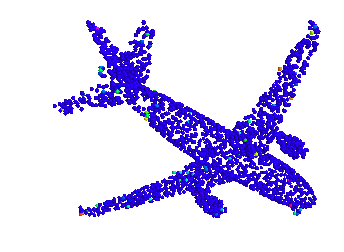

kern_bandwidth           knn
kern_k                    15
feat_alpha                 1
feat_beta                  0
feat_eta                   1
feat_gamma                 1
feat_zeta                  0
ms_bandwidth             1.5
voi                   2.1773
m_voi                7.18828
s_voi             0.00918713
z_voi                545.435
Name: 248, dtype: object
-5


In [47]:

%matplotlib inline
import time
from IPython import display
folders = vois.apply(folder_formatter, axis=1)
i = 0
while i < vois.shape[0]:
    png = folders.iloc[i]
    voi = vois.iloc[i]
    imshow(png+".png")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print(voi)
    back = input()
    if back:
        i -= int(back) + 1
    plt.clf()
    i += 1
    
    


In [42]:
interesting_indices = [89,90,91,92,93,94,101,102,103,104,105,106,113,114,115,116,117,118,206,207,208,209,210,211, 212,213,214,215,216,217, 218,219,220,221,222,223, 230,231,232,233,234,235] 

In [43]:
vois.loc[interesting_indices]

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
89,knn,15,0.0,0.0,0.0,0.0,2.0,1.50,5.062128,8.547970,0.016478,211.544808
90,knn,15,0.0,0.0,0.0,0.0,2.0,1.75,4.711245,8.374411,0.017339,211.273426
91,knn,15,0.0,0.0,0.0,0.0,2.0,2.25,4.055953,7.868334,0.012157,313.586919
92,knn,15,0.0,0.0,0.0,0.0,2.0,2.50,3.792948,7.632287,0.011267,340.751100
93,knn,15,0.0,0.0,0.0,0.0,2.0,2.75,3.736992,7.954541,0.014549,289.893146
94,knn,15,0.0,0.0,0.0,0.0,2.0,3.00,3.357127,6.383861,0.007559,400.389870
101,knn,15,0.0,0.0,1.0,0.0,2.0,1.50,3.420364,6.693732,0.008519,384.254521
102,knn,15,0.0,0.0,1.0,0.0,2.0,1.75,3.178208,6.548018,0.007951,423.821898
103,knn,15,0.0,0.0,1.0,0.0,2.0,2.25,2.656074,5.148733,0.004205,592.831654
104,knn,15,0.0,0.0,1.0,0.0,2.0,2.50,2.533629,5.521756,0.004813,620.848374


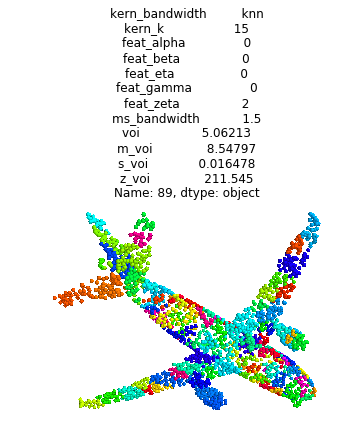

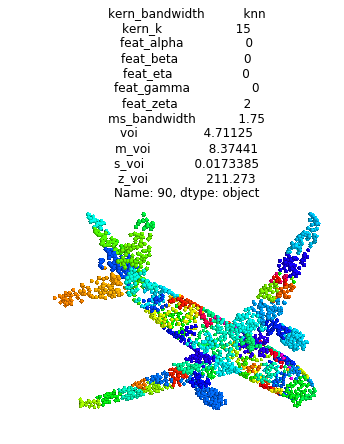

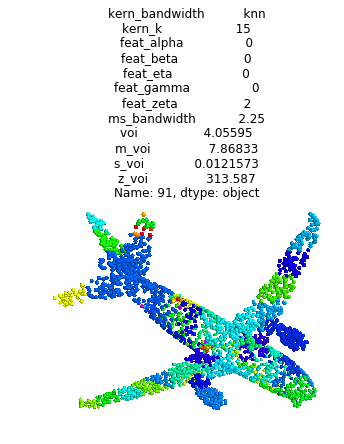

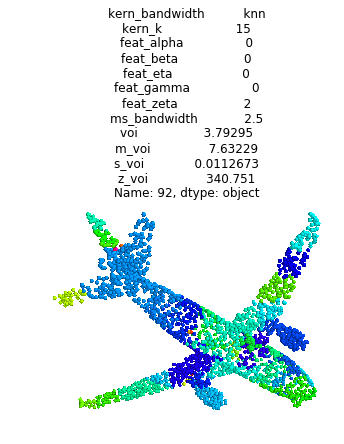

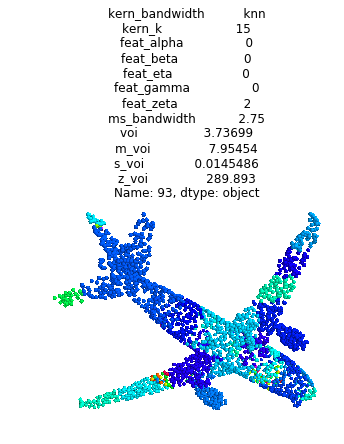

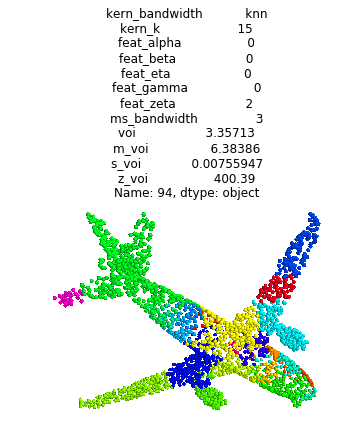

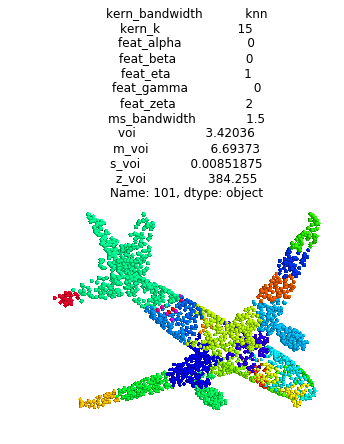

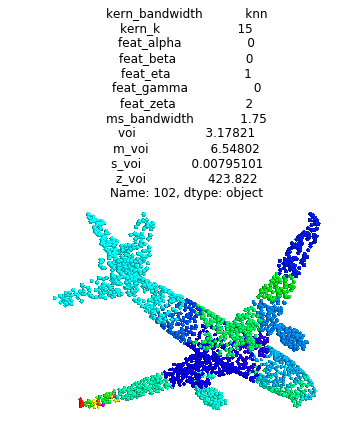

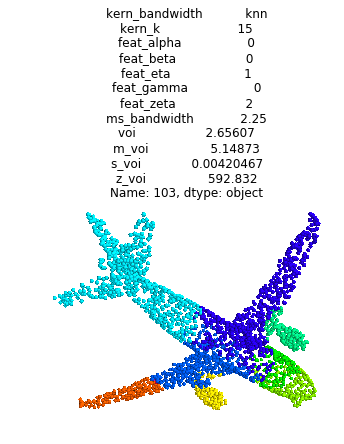

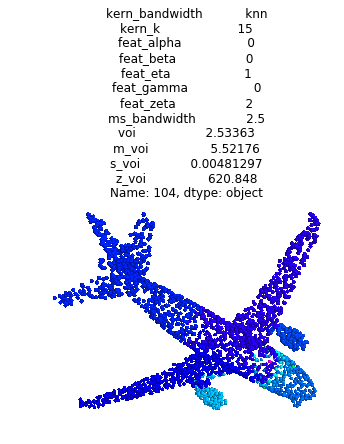

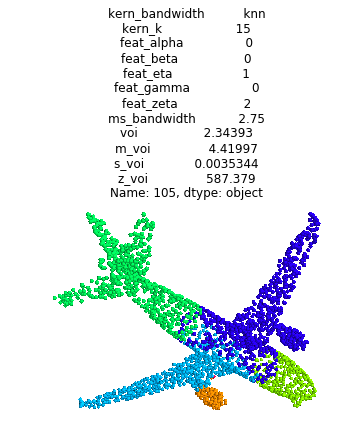

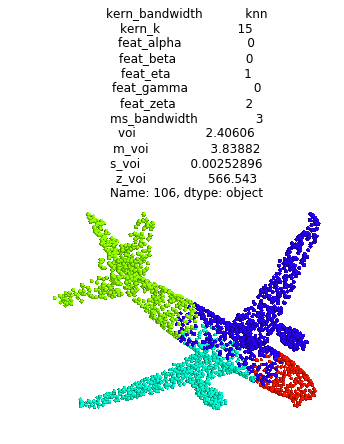

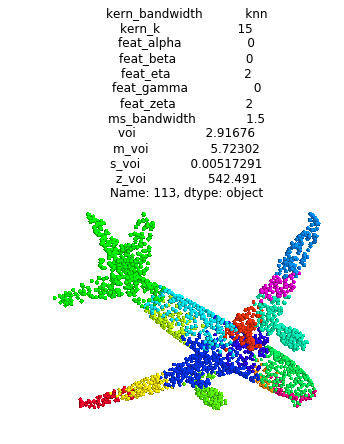

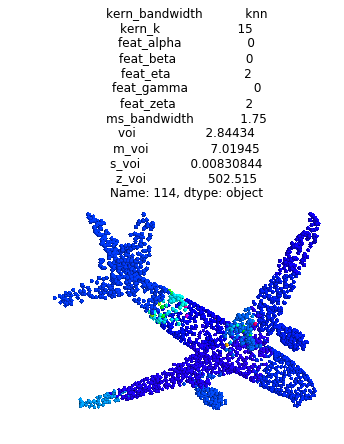

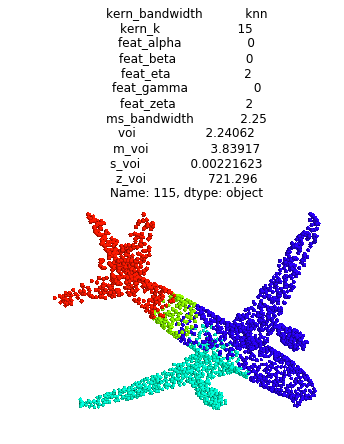

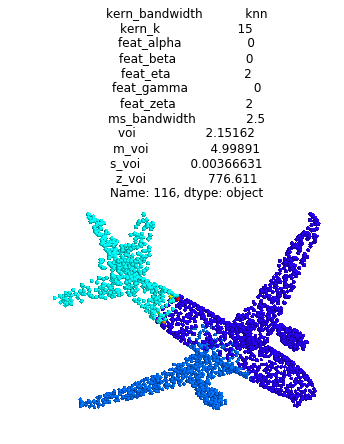

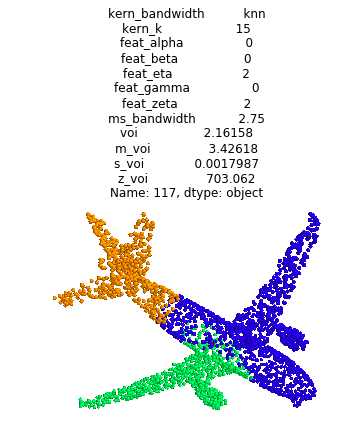

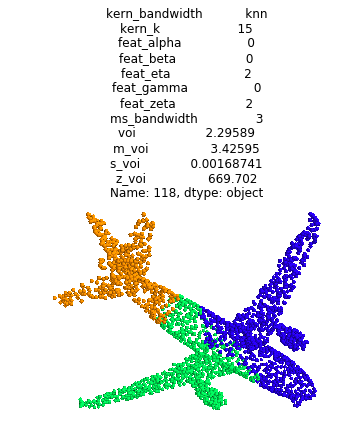

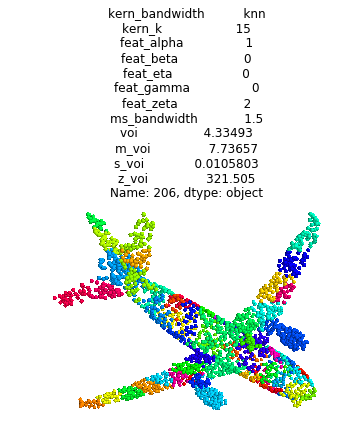

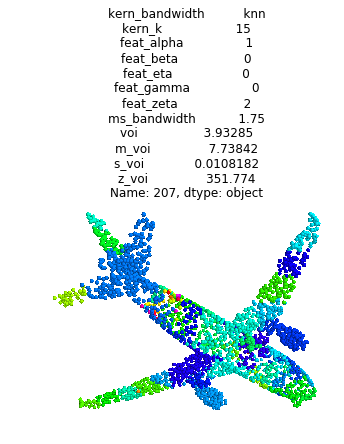

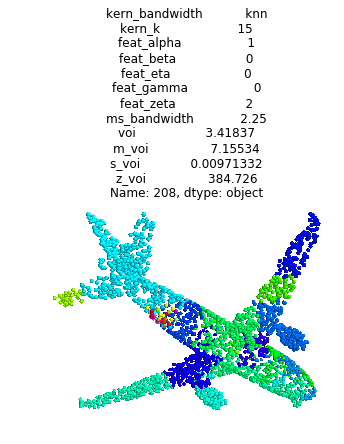

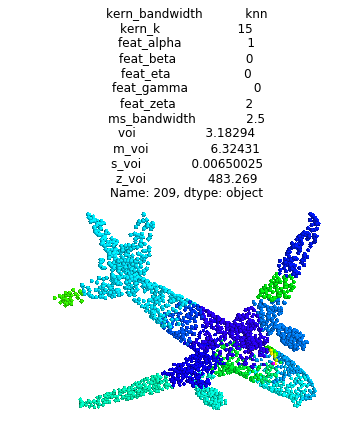

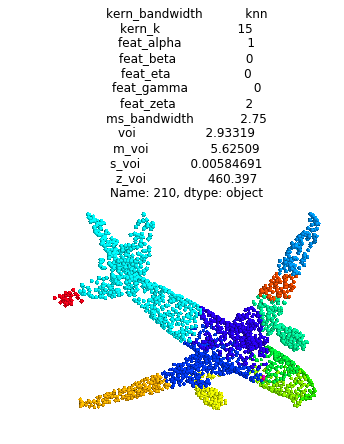

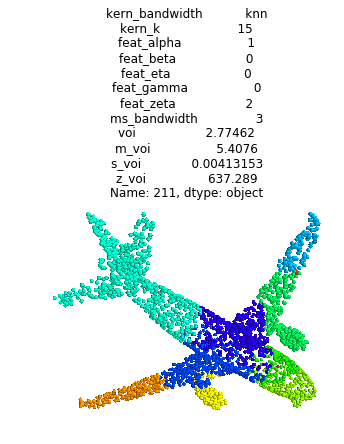

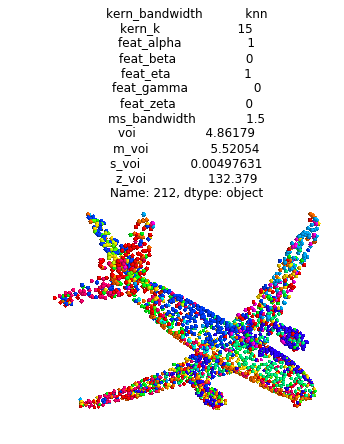

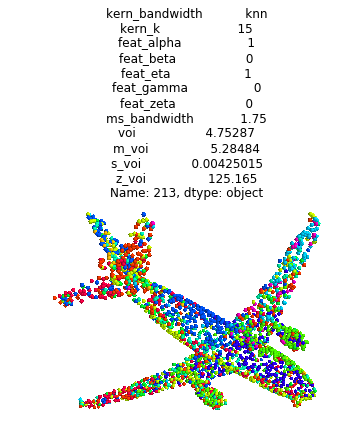

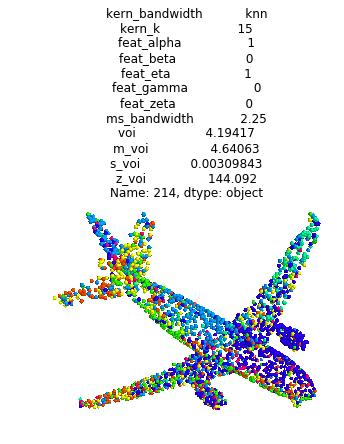

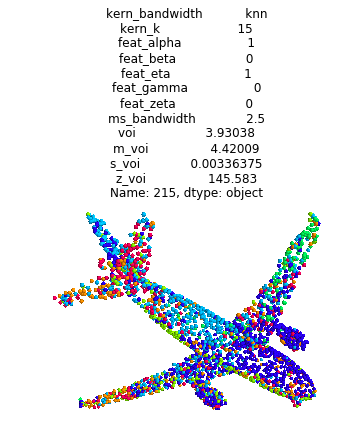

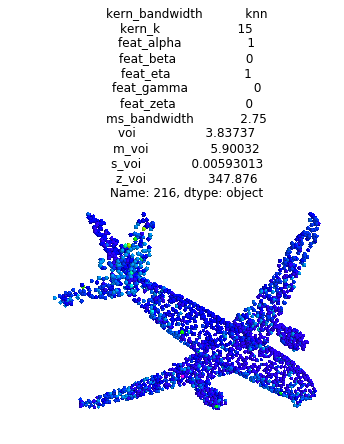

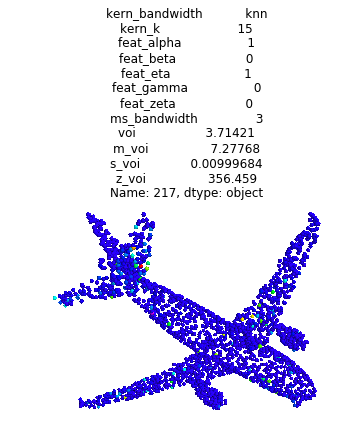

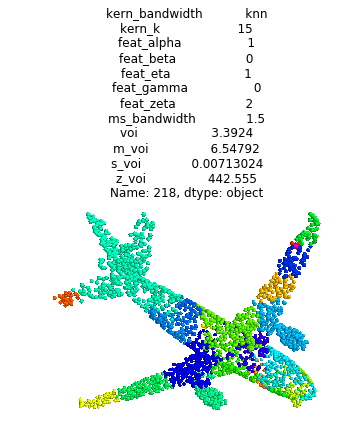

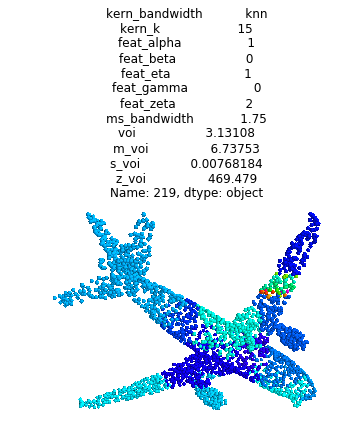

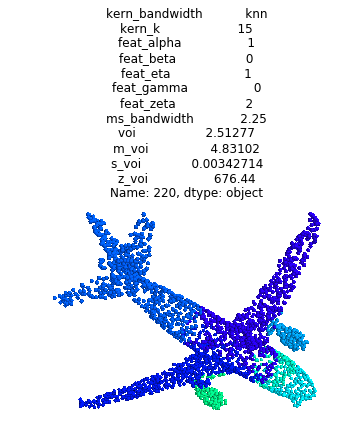

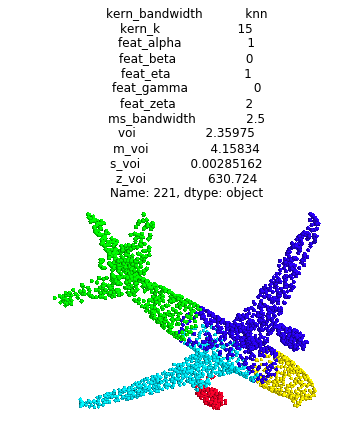

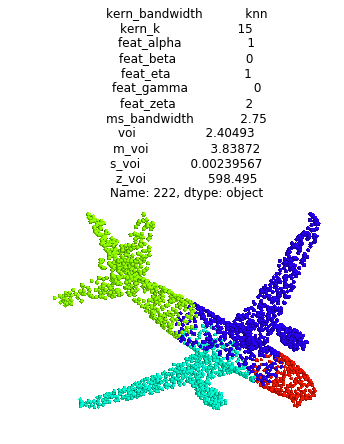

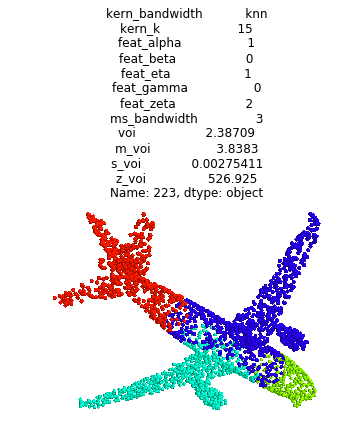

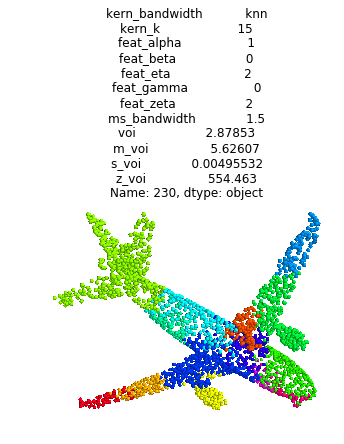

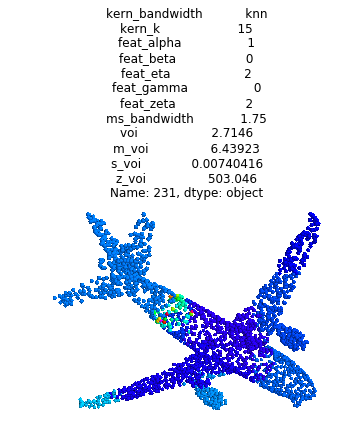

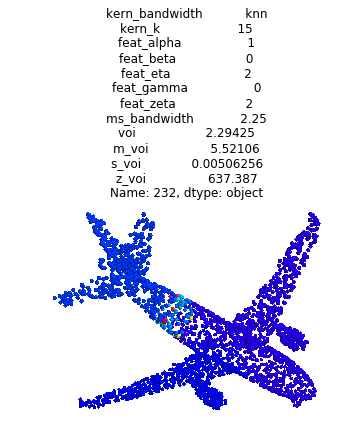

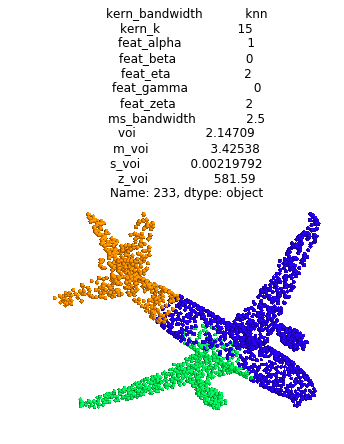

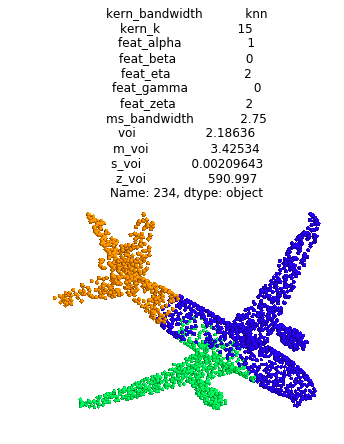

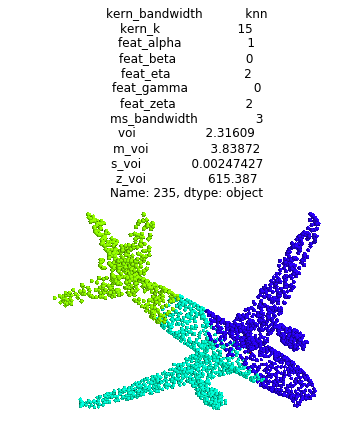

In [46]:
%matplotlib inline
import time
from IPython import display
folders = vois.apply(folder_formatter, axis=1)
for i in interesting_indices:
    plt.figure()
    png = folders.loc[i]
    voi = vois.loc[i]
    imshow(png+".png")
    plt.title(vois.loc[i])
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #plt.clf()

In [98]:
only_alpha_features

,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta
0,False,True,True,True,False
1,False,True,True,True,False
2,False,True,True,True,False
3,False,True,True,True,False
4,False,True,True,True,False
5,False,True,True,True,False
6,False,True,False,True,True
7,False,True,False,True,True
8,False,True,False,True,True
9,False,True,False,True,True


In [103]:
only_alpha_features

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
226    False
227    False
228    False
229    False
230    False
231    False
232    False
233    False
234    False
235    False
236    False
237    False
238    False
239    False
240    False
241    False
242    False
243    False
244    False
245    False
246    False
247    False
248    False
249    False
250     True
251     True
252     True
253     True
254     True
255     True
Length: 256, dtype: bool

In [104]:
vois[only_alpha_features]

,kern_bandwidth,kern_k,feat_alpha,feat_beta,feat_eta,feat_gamma,feat_zeta,ms_bandwidth,voi,m_voi,s_voi,z_voi
250,knn,15,1.0,0.0,0.0,0.0,0.0,1.50,7.875464,9.324687,0.023807,60.873981
251,knn,15,1.0,0.0,0.0,0.0,0.0,1.75,7.390774,9.032657,0.019929,82.386683
252,knn,15,1.0,0.0,0.0,0.0,0.0,2.25,6.197385,8.499222,0.016392,140.425588
253,knn,15,1.0,0.0,0.0,0.0,0.0,2.50,5.984839,8.488760,0.017930,139.650867
254,knn,15,1.0,0.0,0.0,0.0,0.0,2.75,5.324588,7.736867,0.012131,198.857779
255,knn,15,1.0,0.0,0.0,0.0,0.0,3.00,5.128544,7.415940,0.010222,223.777562


In [124]:
only_alpha_features = np.all(vois[["feat_alpha","feat_beta","feat_eta","feat_gamma","feat_zeta"]] == np.array([1,0,0,0,0]),axis=1)
alpha_features_by_segment = []
folders = vois[only_alpha_features].apply(folder_formatter, axis=1)
unique_gt_clusters = np.unique(example_labels)
for i, row in enumerate(vois[only_alpha_features].itertuples()):
    ms_data = np.loadtxt(folders.iloc[i], dtype=np.int64)
    unique_clusters = np.unique(ms_data)
    contingency_table = pd.DataFrame(np.zeros((unique_clusters.shape[0], unique_gt_clusters.shape[0])), 
        index = unique_clusters, columns = unique_gt_clusters)
    alpha_features_by_segment.append(contingency_table)
    for j, cluster in enumerate(ms_data):
        contingency_table.loc[cluster][example_labels[j]] += 1

In [126]:
alpha_features_by_segment[0][alpha_features_by_segment[0].sum(axis=1) > 20]

,1.0,2.0,3.0,4.0
0,21.0,5.0,0.0,6.0
1,29.0,13.0,0.0,3.0
2,3.0,10.0,4.0,5.0
4,7.0,5.0,5.0,17.0
6,11.0,14.0,0.0,3.0
7,4.0,6.0,12.0,2.0
8,112.0,37.0,5.0,12.0
10,7.0,35.0,10.0,15.0
11,23.0,26.0,31.0,15.0
12,12.0,7.0,0.0,5.0


(1510.4591456628461, 4.675641110068017e-44, 816, array([[12.96551724, 10.0815047 ,  4.95297806,  4.        ],
       [18.23275862, 14.17711599,  6.96512539,  5.625     ],
       [ 8.9137931 ,  6.93103448,  3.40517241,  2.75      ],
       ...,
       [ 0.40517241,  0.31504702,  0.15478056,  0.125     ],
       [ 0.40517241,  0.31504702,  0.15478056,  0.125     ],
       [ 0.40517241,  0.31504702,  0.15478056,  0.125     ]]))
(1262.4002062421225, 8.187138154645977e-52, 585, array([[11.75      ,  9.13636364,  4.48863636,  3.625     ],
       [25.52586207, 19.84796238,  9.75117555,  7.875     ],
       [21.87931034, 17.01253918,  8.35815047,  6.75      ],
       [ 2.8362069 ,  2.20532915,  1.08346395,  0.875     ],
       [18.23275862, 14.17711599,  6.96512539,  5.625     ],
       [ 1.21551724,  0.94514107,  0.46434169,  0.375     ],
       [49.02586207, 38.12068966, 18.72844828, 15.125     ],
       [18.63793103, 14.49216301,  7.11990596,  5.75      ],
       [75.36206897, 58.59874608, 

(1019.0023946876652, 5.763658727974668e-65, 357, array([[1.90025862e+02, 1.47757053e+02, 7.25920846e+01, 5.86250000e+01],
       [2.35000000e+01, 1.82727273e+01, 8.97727273e+00, 7.25000000e+00],
       [1.25603448e+01, 9.76645768e+00, 4.79819749e+00, 3.87500000e+00],
       [2.18793103e+01, 1.70125392e+01, 8.35815047e+00, 6.75000000e+00],
       [3.24137931e+00, 2.52037618e+00, 1.23824451e+00, 1.00000000e+00],
       [9.92672414e+01, 7.71865204e+01, 3.79212382e+01, 3.06250000e+01],
       [2.14741379e+01, 1.66974922e+01, 8.20336991e+00, 6.62500000e+00],
       [1.21551724e+01, 9.45141066e+00, 4.64341693e+00, 3.75000000e+00],
       [3.16034483e+01, 2.45736677e+01, 1.20728840e+01, 9.75000000e+00],
       [5.30775862e+01, 4.12711599e+01, 2.02762539e+01, 1.63750000e+01],
       [1.21551724e+00, 9.45141066e-01, 4.64341693e-01, 3.75000000e-01],
       [4.05172414e+00, 3.15047022e+00, 1.54780564e+00, 1.25000000e+00],
       [6.40172414e+01, 4.97774295e+01, 2.44553292e+01, 1.97500000e+01],
  

(800.5679505924367, 2.009314487054387e-89, 150, array([[2.09474138e+02, 1.62879310e+02, 8.00215517e+01, 6.46250000e+01],
       [5.34827586e+01, 4.15862069e+01, 2.04310345e+01, 1.65000000e+01],
       [1.29655172e+01, 1.00815047e+01, 4.95297806e+00, 4.00000000e+00],
       [8.18448276e+01, 6.36394984e+01, 3.12656740e+01, 2.52500000e+01],
       [3.64655172e+00, 2.83542320e+00, 1.39302508e+00, 1.12500000e+00],
       [1.01293103e+02, 7.87617555e+01, 3.86951411e+01, 3.12500000e+01],
       [1.59232759e+02, 1.23813480e+02, 6.08287618e+01, 4.91250000e+01],
       [2.75517241e+01, 2.14231975e+01, 1.05250784e+01, 8.50000000e+00],
       [6.76637931e+01, 5.26128527e+01, 2.58483542e+01, 2.08750000e+01],
       [2.02586207e+00, 1.57523511e+00, 7.73902821e-01, 6.25000000e-01],
       [1.23982759e+02, 9.64043887e+01, 4.73628527e+01, 3.82500000e+01],
       [3.48448276e+01, 2.70940439e+01, 1.33111285e+01, 1.07500000e+01],
       [8.50862069e+00, 6.61598746e+00, 3.25039185e+00, 2.62500000e+00],
   

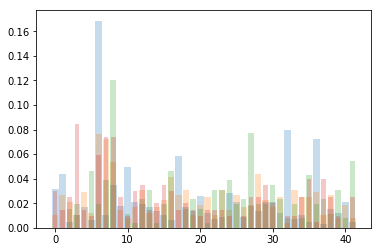

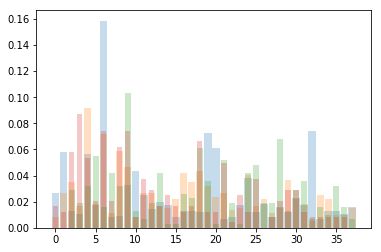

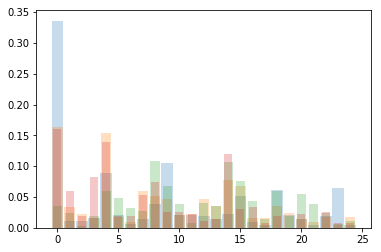

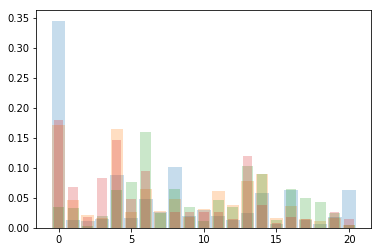

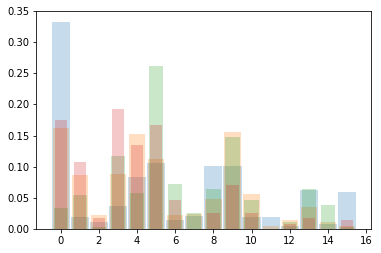

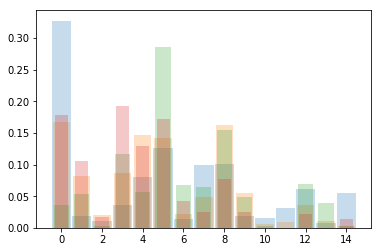

In [134]:
for j, ms_bw in enumerate(alpha_features_by_segment):
    figure = plt.figure()
    ms_bw = ms_bw[ms_bw.sum(axis=1)>20]
    ms_bw = ms_bw/ms_bw.sum(axis=0)
    print(scipy.stats.chi2_contingency(alpha_features_by_segment[j]))
    for i, gt_cluster in enumerate(unique_gt_clusters):
        xs = list(range(ms_bw[gt_cluster].shape[0]))
        ys = [ms_bw.iloc[x][gt_cluster] for x in xs]
        plt.bar(xs, ys, width=0.95 - 0.1*i, alpha=0.25) 

In [139]:
class QuadricParamEstimatorWrapper(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, bandwidth=None, k=None):
        self.bandwidth=bandwidth
        self.k=k
    def fit(self, X, y=None):
        kernel_param_tuple = (("bandwidth", self.bandwidth), ("k", self.k))
        kernel_param_dir = os.path.join(project_dir, str(kernel_param_tuple))
        os.makedirs(kernel_param_dir, exist_ok=1)
        quadric_params_file = os.path.join(kernel_param_dir, "quadric_params")
        kernel = KERNEL(**dict(kernel_param_tuple))
        try:
            quadric_params = np.loadtxt(quadric_params_file)
        except OSError:
            with joblib.parallel_backend("loky", n_jobs=8):
                quadric_params = local_quadrics.transform(X, k=kernel.k, kernel=kernel, weighted=True,
                    parallel=True)
            np.savetxt(quadric_params_file, quadric_params)
        self.quadric_params = quadric_params
    def transform(self, X=None, y=None):
        return self.quadric_params
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform()

In [153]:
class FeatureWeighterWrapper(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, alpha=None, beta=None, gamma=None, eta=None, zeta=None):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.eta=eta
        self.zeta=zeta
    def fit(self, X, y=None):
        print(self.alpha, self.beta, self.gamma, self.eta, self.zeta)
        self.features = featurify_param_vectors(example_data, X, self.alpha, self.beta, self.gamma, self.eta, self.zeta)
    def transform(self, X=None, y=None):
        return self.features
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
        

In [154]:
import sklearn.mixture
four_component_GM = sklearn.mixture.GaussianMixture(4)

In [155]:
import sklearn.pipeline
quadric_n_features_n_gmm_pipeline = sklearn.pipeline.Pipeline([
    ("quadric_transform", QuadricParamEstimatorWrapper()),
    ("feature_weighter", FeatureWeighterWrapper()),
    ("mixture_model", four_component_GM)])

In [167]:
import sklearn.model_selection
grid_search = sklearn.model_selection.GridSearchCV(quadric_n_features_n_gmm_pipeline,
    {
        "quadric_transform__bandwidth": ["knn"],
        "quadric_transform__k": [10,15,20,30],
        "feature_weighter__alpha": [0,1],
        "feature_weighter__beta": [0],
        "feature_weighter__gamma": [0],
        "feature_weighter__eta": [0,1],
        "feature_weighter__zeta": [0,1]
    },
    scoring=sklearn.metrics.make_scorer(VOI),
    cv = ((slice(None), slice(None)),)
)

In [168]:
grid_search.fit(example_data, example_labels)

0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 1
0 0 0 0 1
0 0 0 0 1
0 0 0 0 1
0 0 0 1 0
0 0 0 1 0
0 0 0 1 0
0 0 0 1 0
0 0 0 1 1
0 0 0 1 1
0 0 0 1 1
0 0 0 1 1
1 0 0 0 0
1 0 0 0 0
1 0 0 0 0
1 0 0 0 0
1 0 0 0 1
1 0 0 0 1
1 0 0 0 1
1 0 0 0 1
1 0 0 1 0
1 0 0 1 0
1 0 0 1 0
1 0 0 1 0
1 0 0 1 1
1 0 0 1 1
1 0 0 1 1
1 0 0 1 1
0 0 0 1 0


GridSearchCV(cv=((slice(None, None, None), slice(None, None, None)),),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('quadric_transform',
                                        QuadricParamEstimatorWrapper(bandwidth=None,
                                                                     k=None)),
                                       ('feature_weighter',
                                        FeatureWeighterWrapper(alpha=None,
                                                               beta=None,
                                                               eta=None,
                                                               gamma=None,
                                                               zeta=None)),
                                       ('mixture_model',
                                        GaussianMixture(covariance_type='full',
                                                        ini

In [169]:
grid_search.cv_results_

{'mean_fit_time': array([  0.45194077,   0.39597082,   0.31835151,   0.31717277,
         55.67423511,  56.10152292,  55.63031411,  56.47658992,
         53.28378439,  17.42326164,  20.65995073,  75.54575253,
        105.00550652,  69.927351  ,  69.99017382,  72.73967147,
         27.52181053,  46.26747274,  20.59779096,  72.49198866,
         59.3263731 ,  85.21374416,  72.40607953,  76.3811059 ,
         37.10620046,  47.56592751,  23.81549859,  20.62806678,
         59.68288136,  53.48713613,  56.87939501, 105.87103438]),
 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.8473506 ,
        0.98591161, 0.87216783, 0.85180235, 0.83482671, 0.8636477 ,
        0.86302114, 0.87479663, 0.86084104, 0.86867023, 0.82704496,
        0.88059187, 0.84309769, 0.8536613 , 0.87749934, 0.85931301,
        0.82922673, 0.88380027, 0.8548336 , 0.89840555, 0.87704158,
        0.86373186, 0.8817184 , 0.9144485 , 0.85139465, 0.96693492,
        0.8366766 , 0.86929011]),
 'mean_t

In [172]:
best_one = np.nanargmin(grid_search.cv_results_["split0_test_score"])

In [173]:
grid_search.cv_results_["params"][best_one]

{'feature_weighter__alpha': 1,
 'feature_weighter__beta': 0,
 'feature_weighter__eta': 0,
 'feature_weighter__gamma': 0,
 'feature_weighter__zeta': 1,
 'quadric_transform__bandwidth': 'knn',
 'quadric_transform__k': 20}

In [174]:
best_gmm_fitted = quadric_n_features_n_gmm_pipeline.set_params(**grid_search.cv_results_["params"][best_one]).fit(example_data)

1 0 0 0 1


In [175]:
best_gmm_pred = best_gmm_fitted.predict(example_data)

In [176]:
plot(example_data, best_gmm_pred, os.path.join(project_dir, "best_gmm_pred.png"))

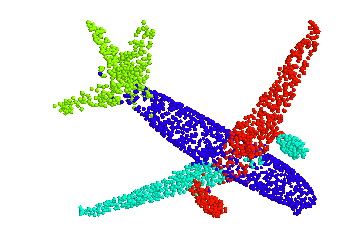

In [177]:
imshow(os.path.join(project_dir, "best_gmm_pred.png"))

In [178]:
positiononly_gmm_fitted = quadric_n_features_n_gmm_pipeline.set_params(**grid_search.cv_results_["params"][5]).fit(example_data)

0 0 0 0 1


In [179]:
positiononly_gmm_pred = positiononly_gmm_fitted.predict(example_data)

In [180]:
plot(example_data, positiononly_gmm_pred, os.path.join(project_dir, "positiononly_gmm_pred.png"))

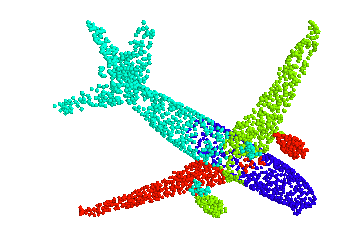

In [181]:
imshow(os.path.join(project_dir, "positiononly_gmm_pred.png"))

In [197]:
kernel_param_kwargs = {"bandwidth":"knn", "k":20}
kernel_param_dir = os.path.join(project_dir, str(tuple(sorted(kernel_param_kwargs.items()))))
some_quadric_features = np.loadtxt(os.path.join(kernel_param_dir, "quadric_params"))
curvy_features = featurify_param_vectors(example_data, some_quadric_features, 1,0,0,0,0)

(2552, 1, 1)
(2552, 2) (2552, 2) (2552, 1) (2552, 3) (2552, 3)


In [198]:
curvy_features.shape

(2552, 11)

In [216]:
blah = curvy_features[:,:3] - np.min(curvy_features[:,:3], axis=0)

In [218]:
blah = blah / np.max(blah, axis=0)

In [220]:
blah[:,2] = 0

In [221]:
blah

array([[0.74441575, 0.69909819, 0.        ],
       [0.22041196, 0.08014532, 0.        ],
       [0.73729308, 0.67454586, 0.        ],
       ...,
       [0.33597465, 0.32619205, 0.        ],
       [0.74627164, 0.71925412, 0.        ],
       [0.78443056, 0.76754072, 0.        ]])

In [225]:
def plt_w_colors(pts, colors, plt_file):
    mayavi.mlab.options.offscreen = True
    figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
    focus = np.average(pts, axis=0)
    dist = np.std(pts, axis=0)

    for i, pt in enumerate(pts):
        node = mayavi.mlab.points3d(pt[0], pt[1], pt[2], color=tuple(colors[i]))

    normalize_view(figure, focus, dist, azimuth=45, elevation=-65, roll=15)
    mayavi.mlab.savefig(plt_file, figure=figure, magnification=2)
    mayavi.mlab.clf(figure)
    mayavi.mlab.close(figure)